
# 🧠 Bayesian Recommendation with Multi-Agent Strategies + Belief Evaluation

This notebook builds on our Bayesian recommendation simulation, comparing **Greedy**, **Random**, and **Thompson Sampling** agents.  
We will visualize belief evolution, track cumulative discounted reward, and **quantify belief quality** using KL divergence and RMSE.  
We also implement an **Early Stopping** mechanism when belief quality worsens.


### 🎯 Objective Function

Maximize the expected long-term discounted return under the current belief:

$$
J(\pi) = \mathbb{E}_{a_t \sim \pi, r_t \sim P(r|a_t, h)} \left[ \sum_{t=0}^T \gamma^t r_t \right]
$$


### 📘 Bayesian Belief Update

At each step, the agent updates its belief about user preference $h$ using Bayes' rule:

$$
P(h | a, r) \propto P(r | a, h) P(h)
$$

Where $P(r | a, h) = \mathcal{N}(r; a \cdot h, \sigma^2)$ — a Gaussian likelihood.

### 📏 Metrics for Fit Quality

- **KL Divergence** to the true posterior
- **RMSE** between posterior mean and true $h^*$:

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (\hat{h}_i - h^*)^2}
$$


In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# 🔧 Parameters
true_h = 0.72
sigma = 0.07
gamma = 0.95
actions = np.linspace(0.1, 0.9, 9)
h_grid = np.linspace(0, 1, 500)
steps = 20

# Early Stopping settings
patience = 3  # how many consecutive worsening steps to allow


In [2]:

def reward(h, a, sigma=sigma):
    return np.exp(- (a - h)**2 / (2 * sigma**2))

def update_belief(prior, action):
    likelihood = reward(h_grid, action)
    posterior = prior * likelihood
    posterior /= np.trapz(posterior, h_grid)
    return posterior

def expected_reward(belief, action):
    r = reward(h_grid, action)
    return np.trapz(r * belief, h_grid)

def compute_metrics(belief):
    # true distribution (narrow Gaussian at true_h)
    p_true = np.exp(- (h_grid - true_h)**2 / (2 * (sigma/2)**2))
    p_true /= np.trapz(p_true, h_grid)
    # KL divergence
    kl = entropy(p_true, belief)
    # RMSE: difference between posterior mean and true_h
    mean = np.trapz(h_grid * belief, h_grid)
    rmse = np.sqrt((mean - true_h)**2)
    return kl, rmse


In [3]:

# Initialize beliefs and tracking
agents = ['Greedy', 'Random', 'Thompson']
beliefs = {agent: np.ones_like(h_grid) for agent in agents}
cum_rewards = {agent: [] for agent in agents}
kl_history = {agent: [] for agent in agents}
rmse_history = {agent: [] for agent in agents}
stop_flags = {agent: False for agent in agents}
worse_counts = {agent: 0 for agent in agents}

np.random.seed(42)

for t in range(steps):
    for agent in agents:
        if stop_flags[agent]:
            # hold belief if stopped
            kl_history[agent].append(kl_history[agent][-1])
            rmse_history[agent].append(rmse_history[agent][-1])
            cum_rewards[agent].append(cum_rewards[agent][-1])
            continue

        b = beliefs[agent]
        # select action
        if agent == 'Greedy':
            a = actions[np.argmax([expected_reward(b, act) for act in actions])]
        elif agent == 'Random':
            a = np.random.choice(actions)
        else:  # Thompson
            h_sample = np.random.choice(h_grid, p=b/np.sum(b))
            a = actions[np.argmin(np.abs(actions - h_sample))]

        # get reward and update cumulative discounted reward
        r = reward(true_h, a)
        prev = cum_rewards[agent][-1] if cum_rewards[agent] else 0.0
        cum = prev + (gamma ** t) * r
        cum_rewards[agent].append(cum)

        # update belief
        new_b = update_belief(b, a)
        beliefs[agent] = new_b

        # compute metrics
        kl, rmse = compute_metrics(new_b)
        kl_history[agent].append(kl)
        rmse_history[agent].append(rmse)

        # Early stopping check
        if t > 0 and kl_history[agent][-1] > kl_history[agent][-2]:
            worse_counts[agent] += 1
            if worse_counts[agent] >= patience:
                stop_flags[agent] = True
        else:
            worse_counts[agent] = 0


C:\Users\liuzu\AppData\Local\Temp\ipykernel_80564\2298483043.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(r * belief, h_grid)
C:\Users\liuzu\AppData\Local\Temp\ipykernel_80564\2298483043.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  posterior /= np.trapz(posterior, h_grid)
C:\Users\liuzu\AppData\Local\Temp\ipykernel_80564\2298483043.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_true /= np.trapz(p_true, h_grid)
C:\Users\liuzu\AppData\Local\Temp\ipykernel_80564\2298483043.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean = np.trapz(h_grid * belief, h_grid)


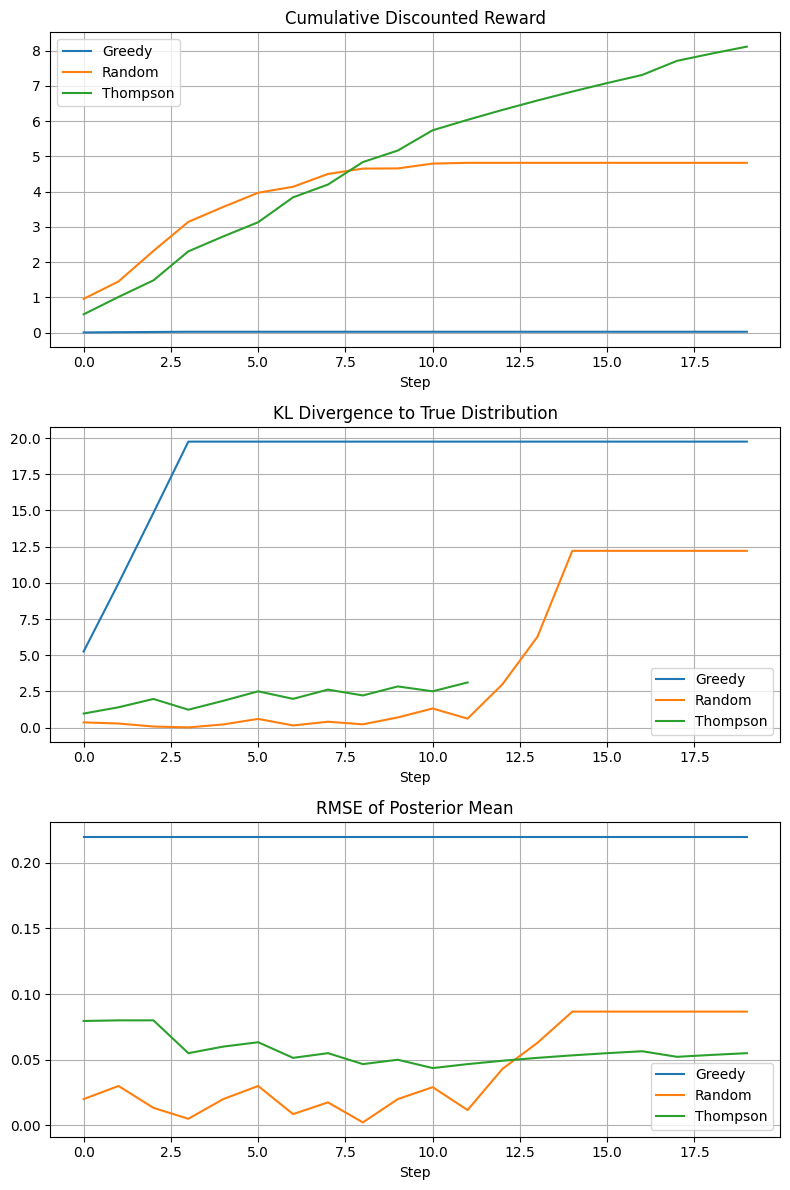

,Agent,Stopped Early
0,Greedy,True
1,Random,True
2,Thompson,False


In [4]:

# Plot results
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

for agent in agents:
    axs[0].plot(cum_rewards[agent], label=agent)
    axs[1].plot(kl_history[agent], label=agent)
    axs[2].plot(rmse_history[agent], label=agent)

axs[0].set_title('Cumulative Discounted Reward')
axs[1].set_title('KL Divergence to True Distribution')
axs[2].set_title('RMSE of Posterior Mean')

for ax in axs:
    ax.set_xlabel('Step')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

# Display early stopping status
import pandas as pd
stop_df = pd.DataFrame({
    'Agent': agents,
    'Stopped Early': [stop_flags[a] for a in agents]
})
display(stop_df)
